<a href="https://colab.research.google.com/github/TimHBSWFL/UCSD-ML-Capstone/blob/main/bert_yelp_reviews_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

In [2]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

pipeline = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
filename = "FL_Reviews_Edited" + ".csv"
directory = '/content/drive/My Drive/Capstone Data Collection/'

path = directory + filename

chunk_iterator = pd.read_csv(path, chunksize=10000)

chunks = []

for chunk in chunk_iterator:
  chunks.append(chunk)

df_reviews = pd.concat(chunks, ignore_index=True)

df_sample = df_reviews.sample(frac=0.05, random_state=42)
df_sample.shape

(39607, 24)

In [9]:
df_subset = df_sample[['text', 'stars_reviews']]

In [10]:
batch_size = 64

def predict_in_batches(df, batch_size=64):
    predictions = []

    for start in range(0, len(df), batch_size):
        end = min(start + batch_size, len(df))
        batch_reviews = df['text'][start:end].tolist()

        inputs = pipeline.tokenizer(batch_reviews, truncation=True, max_length=512, padding=True, return_tensors='pt')
        with torch.no_grad():
            batch_outputs = model(**inputs.to(model.device))

        for i in range(len(batch_reviews)):
            scores = batch_outputs.logits[i].softmax(dim=0)
            predicted_rating = int(scores.argmax()) + 1
            predictions.append(predicted_rating)

        if start // batch_size % 25 == 0:
            print(f"Processed batch {start // batch_size + 1} of {len(df) // batch_size + 1}")

    return predictions

df_subset['predicted_rating'] = predict_in_batches(df_subset, batch_size)

Processed batch 1 of 619
Processed batch 26 of 619
Processed batch 51 of 619
Processed batch 76 of 619
Processed batch 101 of 619
Processed batch 126 of 619
Processed batch 151 of 619
Processed batch 176 of 619
Processed batch 201 of 619
Processed batch 226 of 619
Processed batch 251 of 619
Processed batch 276 of 619
Processed batch 301 of 619
Processed batch 326 of 619
Processed batch 351 of 619
Processed batch 376 of 619
Processed batch 401 of 619
Processed batch 426 of 619
Processed batch 451 of 619
Processed batch 476 of 619
Processed batch 501 of 619
Processed batch 526 of 619
Processed batch 551 of 619
Processed batch 576 of 619
Processed batch 601 of 619


<ipython-input-10-4bcd86520716>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['predicted_rating'] = predict_in_batches(df_subset, batch_size)


In [11]:
df_subset.head()

,text,stars_reviews,predicted_rating
91575,Got an email talking about new place to try an...,5,4
398413,The absolute best fried chicken that I have ha...,5,5
611701,"Honestly the worst, most tasteless food. We bo...",1,1
786744,Overall great tapas. They have a little of eve...,4,4
625527,This is a Tampa must do! Top your dinner off i...,5,5


In [12]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(df_subset['stars_reviews'], df_subset['predicted_rating'])
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.38942611154593887


In [13]:
accuracy = (df_subset['stars_reviews'] == df_subset['predicted_rating']).mean()
print("Accuracy:", accuracy)

Accuracy: 0.6779862145580327


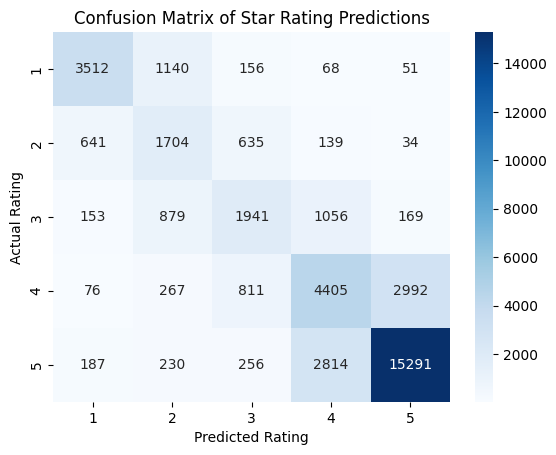

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(df_subset['stars_reviews'], df_subset['predicted_rating'])
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Confusion Matrix of Star Rating Predictions")
plt.show()

Alternative BERT Model

In [19]:
distilbert_model_name = "distilbert-base-uncased-finetuned-sst-2-english"
distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_model_name)
distilbert_model = AutoModelForSequenceClassification.from_pretrained(distilbert_model_name)

# Create a pipeline for sentiment analysis
distilbert_pipeline = TextClassificationPipeline(
    model=distilbert_model,
    tokenizer=distilbert_tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    truncation=True,
    max_length=512
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
df_distilbert = df_sample[df_sample['stars_reviews'].isin([1, 5])]
df_distilbert.shape

(23705, 24)

In [32]:
df_distilbert_sub = df_distilbert[['text', 'stars_reviews']]

In [33]:
batch_size = 64


def predict_in_batches(df, batch_size=64):
    ratings = []

    for start in range(0, len(df), batch_size):
        end = min(start + batch_size, len(df))
        batch_reviews = df['text'][start:end].tolist()

        batch_predictions = distilbert_pipeline(batch_reviews)

        for prediction in batch_predictions:
            sentiment = prediction['label']
            rating = 5 if sentiment == 'POSITIVE' else 1
            ratings.append(rating)

        if start // batch_size % 25 == 0:
            print(f"Processed batch {start // batch_size + 1} of {len(df) // batch_size + 1}")

    return ratings


df_distilbert_sub['predicted_rating'] = predict_in_batches(df_distilbert_sub, batch_size)

Processed batch 1 of 371
Processed batch 26 of 371
Processed batch 51 of 371
Processed batch 76 of 371
Processed batch 101 of 371
Processed batch 126 of 371
Processed batch 151 of 371
Processed batch 176 of 371
Processed batch 201 of 371
Processed batch 226 of 371
Processed batch 251 of 371
Processed batch 276 of 371
Processed batch 301 of 371
Processed batch 326 of 371
Processed batch 351 of 371


<ipython-input-33-72ae43fb695d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distilbert_sub['predicted_rating'] = predict_in_batches(df_distilbert_sub, batch_size)


In [34]:
mae = mean_absolute_error(df_distilbert_sub['stars_reviews'], df_distilbert_sub['predicted_rating'])
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.09938831470153976


In [35]:
accuracy = (df_distilbert_sub['stars_reviews'] == df_distilbert_sub['predicted_rating']).mean()
print(f"Accuracy:", accuracy)

Accuracy: 0.9751529213246151


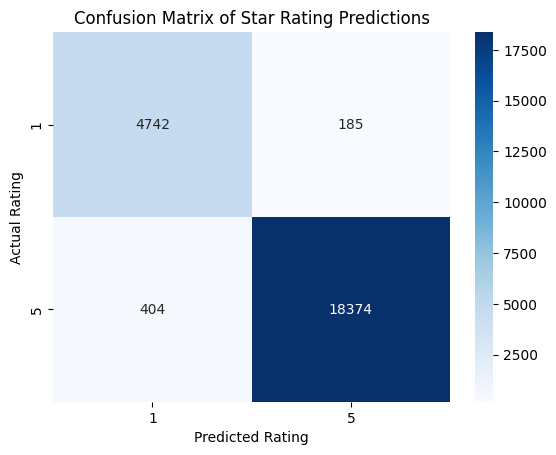

In [40]:
conf_matrix = confusion_matrix(df_distilbert_sub['stars_reviews'], df_distilbert_sub['predicted_rating'])
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=[1, 5], yticklabels=[1, 5])
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Confusion Matrix of Star Rating Predictions")
plt.show()